In [65]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.backends.cudnn as cudnn
import os
from tqdm import tqdm
import time
import numpy as np
import torch.utils.data as data
from skimage import io, transform, img_as_float
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import random
from skimage.filters import rank
import skimage.morphology as morp

In [90]:
our_transformation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.3403, 0.3121, 0.3214),
                         (0.2724, 0.2608, 0.2669))
])
tr = transforms.ToPILImage()
BATCH_SIZE = 100
LEARNING_RATE = 0.1
classesNumber = 43 
list_counter = [210,2220,2250,1410,1980,1860,420,1440,1410,1470,2010,1320,2100,2160,780,630,420,1110,1200,210,360,330,390,510,270,1500,600,240,540,270,450,780,240,689,420,1200,390,198,2070,300,360,240,240] 

In [91]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

'cuda'

In [92]:
class TrainingDataSetPortion(torch.utils.data.Dataset):

    def __init__(self, number_images, root_dir, label, transform=None):
        self.number_images = number_images
        self.targets = [label]*self.number_images
        self.root_dir = root_dir+'/'+str(label)
        self.transform = transform

    def __len__(self):
        return self.number_images

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = os.path.join(self.root_dir, str(idx+1)+'.ppm')
        image = io.imread(img_name)
        resized_img = transform.resize(image, (32, 32))
        sample = img_as_float(resized_img)

        if self.transform:
            sample = self.transform(sample)
        sample = sample.float()
        target = self.targets[idx]
        return [sample,target]

class TestingDataSetPortion(torch.utils.data.Dataset):

    def __init__(self, number_images, root_dir, transform=None):
        self.number_images = number_images
        with open(root_dir+'/labels.txt', 'r') as file:
            self.targets=list(file.read().splitlines())
        #print(type(self.targets[0]))
        self.targets = [int(float(self.targets[i])) for i in range(len(self.targets))]
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return self.number_images

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = os.path.join(self.root_dir, str("{:05d}".format(idx))+'.ppm')
        image = io.imread(img_name)
        resized_img = transform.resize(image, (32, 32))
        sample = img_as_float(resized_img)

        if self.transform:
            sample = self.transform(sample)
        
        return [sample.float(), self.targets[idx]]

In [93]:
#Loading training dataset
trainingDataset = []
for i in range(43):
    trainingDataset.append(TrainingDataSetPortion(list_counter[i],
                                          './SemProj/data/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images',
                                          i,
                                          our_transformation))
trainingDataset = torch.utils.data.ConcatDataset(trainingDataset)
#Creating the training loader
trainingDataLoader = torch.utils.data.DataLoader(trainingDataset, batch_size=BATCH_SIZE, shuffle=True)

In [95]:
# For this code, I took it from internet and more precisely from this website:
# https://github.com/pytorch/vision/issues/1049
def torch_equalize(image):
    def scale_channel(im, c):
        print(c)
        im = im[c, :, :]
        # Compute the histogram of the image channel.
        histo = torch.histc(im, bins=256, min=0, max=255)
        print(histo)
        # For the purposes of computing the step, filter out the nonzeros.
        nonzero_histo = torch.reshape(histo[histo != 0], [-1])
        step = (torch.sum(nonzero_histo) - nonzero_histo[-1]) // 255
        def build_lut(histo, step):
            # Compute the cumulative sum, shifting by step // 2
            # and then normalization by step.
            lut = (torch.cumsum(histo, 0) + (step // 2)) // step
            # Shift lut, prepending with 0.
            lut = torch.cat([torch.zeros(1), lut[:-1]]) 
            # Clip the counts to be in range.  This is done
            # in the C code for image.point.
            return torch.clamp(lut, 0, 255)

        # If step is zero, return the original image.  Otherwise, build
        # lut from the full histogram and step and then index from it.
        if step == 0:
            result = im
        else:
            # can't index using 2d index. Have to flatten and then reshape
            result = torch.gather(build_lut(histo, step), 0, im.flatten().long())
            result = result.reshape_as(im)
        
        return result.type(torch.uint8)

    # Assumes RGB for now.  Scales each channel independently
    # and then stacks the result.
    s1 = scale_channel(image, 0)
    s2 = scale_channel(image, 1)
    s3 = scale_channel(image, 2)
    image = torch.stack([s1, s2, s3], 2)
    return image

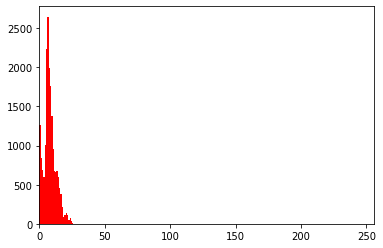

(77, 85, 3)


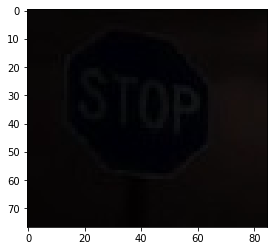

In [88]:
import cv2
import numpy as np

img = cv2.imread('darkerr_stop.jpg')
hist,bins = np.histogram(img.flatten(),256,[0,256])
plt.hist(img.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.show()
plt.imshow(img)
print(np.shape(img))

In [89]:
def histogram_equalization(img_in):
# segregate color streams
    b,g,r = cv2.split(img_in)
    h_b, bin_b = np.histogram(b.flatten(), 256, [0, 256])
    h_g, bin_g = np.histogram(g.flatten(), 256, [0, 256])
    h_r, bin_r = np.histogram(r.flatten(), 256, [0, 256])
# calculate cdf    
    cdf_b = np.cumsum(h_b)  
    cdf_g = np.cumsum(h_g)
    cdf_r = np.cumsum(h_r)
    
# mask all pixels with value=0 and replace it with mean of the pixel values 
    cdf_m_b = np.ma.masked_equal(cdf_b,0)
    cdf_m_b = (cdf_m_b - cdf_m_b.min())*255/(cdf_m_b.max()-cdf_m_b.min())
    cdf_final_b = np.ma.filled(cdf_m_b,0).astype('uint8')
  
    cdf_m_g = np.ma.masked_equal(cdf_g,0)
    cdf_m_g = (cdf_m_g - cdf_m_g.min())*255/(cdf_m_g.max()-cdf_m_g.min())
    cdf_final_g = np.ma.filled(cdf_m_g,0).astype('uint8')
    cdf_m_r = np.ma.masked_equal(cdf_r,0)
    cdf_m_r = (cdf_m_r - cdf_m_r.min())*255/(cdf_m_r.max()-cdf_m_r.min())
    cdf_final_r = np.ma.filled(cdf_m_r,0).astype('uint8')
# merge the images in the three channels
    img_b = cdf_final_b[b]
    img_g = cdf_final_g[g]
    img_r = cdf_final_r[r]
  
    img_out = cv2.merge((img_b, img_g, img_r))
# validation
    equ_b = cv2.equalizeHist(b)
    equ_g = cv2.equalizeHist(g)
    equ_r = cv2.equalizeHist(r)
    equ = cv2.merge((equ_b, equ_g, equ_r))
    #print(equ)
    #cv2.imwrite('output_name.png', equ)
    return img_out

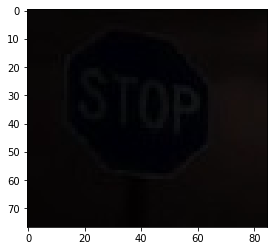

In [43]:
#img = transform.resize(img, (32, 32))
plt.imshow(img)
img = histogram_equalization(img)

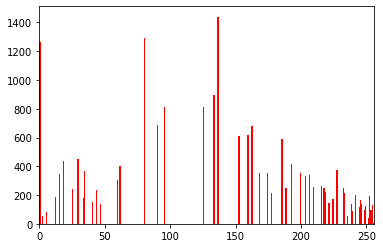

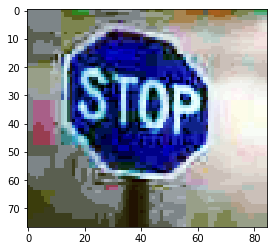

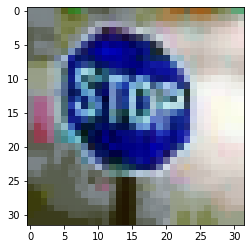

In [44]:
hist,bins = np.histogram(img.flatten(),256,[0,256])
plt.hist(img.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.show()
plt.imshow(img)
img = transform.resize(img, (32, 32))
plt.figure()
plt.imshow(img)

In [45]:
import numpy as np
import matplotlib.pyplot as plt


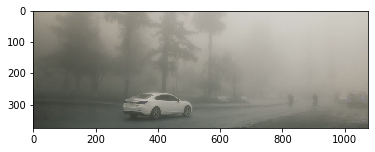

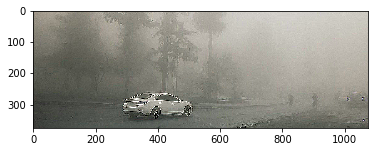

In [46]:
img1 = cv2.imread('foggy.jpg',1)
plt.imshow(img1)
plt.figure()
# Creating our sharpening filter
filter = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
# Applying cv2.filter2D function on our Cybertruck image
sharpen_img_1=cv2.filter2D(img1,-1,filter)
plt.imshow(sharpen_img_1)

In [214]:
#useless cell
from skimage import color, data, restoration

astro = color.rgb2gray(img)
from scipy.signal import convolve2d as conv2
psf = np.ones((5, 5)) / 25
astro = conv2(astro, psf, 'same')
astro += 0.1 * astro.std() * np.random.standard_normal(astro.shape)

In [53]:
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)

In [54]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
class PreActBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(PreActBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)

        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes,
                          kernel_size=1, stride=stride, bias=False)
            )

    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))
        out += shortcut
        return out

In [55]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = conv3x3(3, 64)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def freeze_hidden_layers(self):
        self._freeze_layer(self.conv1)
        self._freeze_layer(self.bn1)
        self._freeze_layer(self.layer1)
        self._freeze_layer(self.layer2)
        self._freeze_layer(self.layer3)
        self._freeze_layer(self.layer4)

    def unfreeze_model(self):
        self._freeze_layer(self.conv1, freeze=False)
        self._freeze_layer(self.bn1, freeze=False)
        self._freeze_layer(self.layer1, freeze=False)
        self._freeze_layer(self.layer2, freeze=False)
        self._freeze_layer(self.layer3, freeze=False)
        self._freeze_layer(self.layer4, freeze=False)
        self._freeze_layer(self.linear, freeze=False)

    def embed_in_n_layer(self, n):
        self._freeze_layer(self.conv1)
        self._freeze_layer(self.bn1)
        if n == 1:
            self._freeze_layer(self.layer1)
        elif n == 2:
            self._freeze_layer(self.layer2)
        elif n == 3:
            self._freeze_layer(self.layer3)
        elif n == 4:
            self._freeze_layer(self.layer4)
        else:
            self._freeze_layer(self.linear)

    def _freeze_layer(self, layer, freeze=True):
        if freeze:
            for p in layer.parameters():
                p.requires_grad = False
        else:
            for p in layer.parameters():
                p.requires_grad = True

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [56]:
def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3],classesNumber)
def ResNet18():
    return ResNet(PreActBlock, [2, 2, 2, 2],classesNumber)
def train(trainloader,epochs=1, model=None):
    if model==None:
        model = ResNet34()
        model.to(device)
    loss_function=nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE) 
    for epoch in tqdm(range(epochs)):
        total_loss = 0
        for batch_idx, (images, labels) in enumerate(trainloader):
            images=images.to(device)
            labels=labels.to(device)
            optimizer.zero_grad() 
            preds = model(images)
            loss = loss_function(preds,labels)
            loss.backward() 
            optimizer.step() 
            total_loss += loss.item()
        del images
        del labels
    return model
def test(model, test_loader, filt):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            noise = np.random.normal(0, 0.2, images.size())
            images = filt(images+torch.LongTensor(5*noise).cuda())
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print(correct)
    return 100 * correct / total

In [57]:
BBox_loader = torch.load('./BlackBox')
# This is just to instantiate the model undirectly, we can replace it by a simple instantiation
# But I put it like that so if we change the BBox architecture at some in time, we won't be asked to change this part here.
BB = train(trainingDataLoader,0)
BB.load_state_dict(BBox_loader['model_state_dict'])
BB.eval()
def BlackBox(tensor):
    '''
    Now the Black Box model is accessible through the interface BlackBox
    The interface accepts a DataLoader that contains images only without labels!
    '''
    #Apply the right transformation on the data here before passing it to the model.
    
    with torch.no_grad():
        predictions = BB(tensor).argmax(dim=1)
    return predictions

0it [00:00, ?it/s]


Before correction, the model says that this is:
3
After correction, the model says that this is: 
17


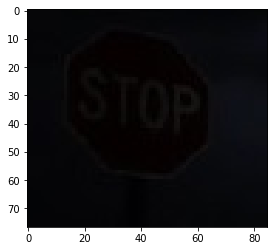

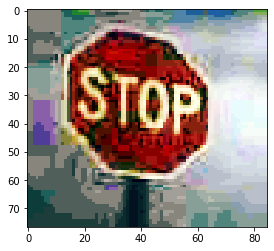

In [58]:
img = plt.imread('darkerr_stop.jpg')
print("Before correction, the model says that this is:")
plt.imshow(img)
print(BB(our_transformation(transform.resize(img, (32, 32))).unsqueeze(dim=0).float().cuda()).argmax(dim=1).item())
print("After correction, the model says that this is: ")
plt.figure()
img = histogram_equalization(img)
plt.imshow(img)
print(BB(our_transformation(transform.resize(img, (32, 32))).unsqueeze(dim=0).float().cuda()).argmax(dim=1).item())

Before correction, the model says that this is:


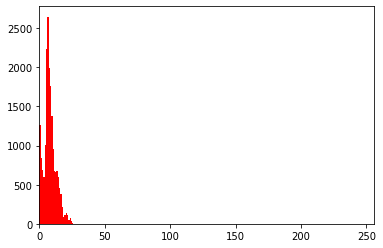

3
After correction, the model says that this is: 
17


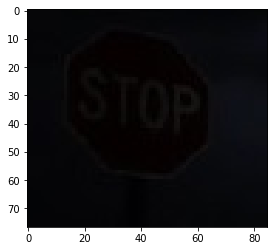

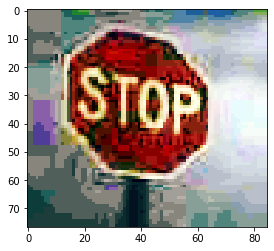

In [103]:
img = plt.imread('darkerr_stop.jpg')
print("Before correction, the model says that this is:")
'''
x = img[:,:,0]
img[:,:,0] = img[:,:,2]
img[:,:,2] = x
'''
hist,bins = np.histogram(img.flatten(),256,[0,256])
plt.hist(img.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.show()
plt.imshow(img)
print(BB(our_transformation(transform.resize(img, (32, 32))).unsqueeze(dim=0).float().cuda()).argmax(dim=1).item())
print("After correction, the model says that this is: ")
plt.figure()
img = histogram_equalization(img)
plt.imshow(img)
print(BB(our_transformation(transform.resize(img, (32, 32))).unsqueeze(dim=0).float().cuda()).argmax(dim=1).item())

In [61]:
class TestingDataSetPortion(torch.utils.data.Dataset):

    def __init__(self, number_images, root_dir, transform=None):
        self.number_images = number_images
        with open(root_dir+'/labels.txt', 'r') as file:
            self.targets=list(file.read().splitlines())
        #print(type(self.targets[0]))
        self.targets = [int(float(self.targets[i])) for i in range(len(self.targets))]
        self.root_dir = root_dir
        self.transform = transform
        self.kernel = morp.disk(30)

    def __len__(self):
        return self.number_images

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = os.path.join(self.root_dir, str("{:05d}".format(idx))+'.ppm')
        image = io.imread(img_name)
        resized_img = transform.resize(image, (32, 32))
        sample = img_as_float(resized_img)
        real_image = np.zeros((32,32,1))
        real_image = 0.2125*sample[:,:,0] + 0.7154*sample[:,:,1] + 0.0721*sample[:,:,2]
        sample = real_image
        sample = rank.equalize(sample, selem=self.kernel)
        if self.transform:
            sample = self.transform(sample)
        
        return [sample.float(), self.targets[idx]]

In [97]:
BB_gray = torch.hub.load('pytorch/vision', 'resnet34', pretrained=True)
BB_gray.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
BB_gray.fc = nn.Linear(in_features=512, out_features=classesNumber, bias=True)
BBox_loader = torch.load('./BlackBox_gray')
# This is just to instantiate the model undirectly, we can replace it by a simple instantiation
# But I put it like that so if we change the BBox architecture at some in time, we won't be asked to change this part here.
BB_gray.load_state_dict(BBox_loader['model_state_dict'])
BB_gray.to(device).eval()


Using cache found in C:\Users\Utilisateur/.cache\torch\hub\pytorch_vision_master


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Before correction, the model says that this is:
25
After correction, the model says that this is: 
14


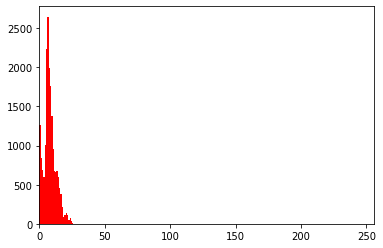

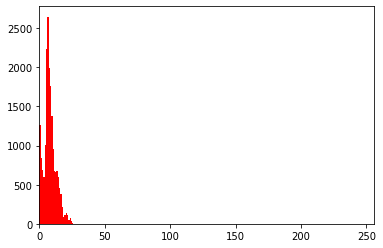

In [102]:
kernel = morp.disk(30)
img = plt.imread('darkerr_stop.jpg')
print("Before correction, the model says that this is:")
hist,bins = np.histogram(img.flatten(),256,[0,256])
plt.hist(img.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
#plt.show()
#plt.imshow(img)
resized_img = transform.resize(img, (32, 32))
sample = img_as_float(resized_img)
real_image = np.zeros((32,32,1))
real_image = 0.2125*sample[:,:,0] + 0.7154*sample[:,:,1] + 0.0721*sample[:,:,2]
sample = real_image
print(BB_gray((transforms.ToTensor()(sample)).unsqueeze(dim=0).float().cuda()).argmax(dim=1).item())
plt.figure()
print("After correction, the model says that this is: ")
img = plt.imread('darkerr_stop.jpg')
hist,bins = np.histogram(img.flatten(),256,[0,256])
plt.hist(img.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
#plt.show()
#plt.imshow(img)
img = histogram_equalization(img)
resized_img = transform.resize(img, (32, 32))
sample = img_as_float(resized_img)
real_image = np.zeros((32,32,1))
real_image = 0.2125*sample[:,:,0] + 0.7154*sample[:,:,1] + 0.0721*sample[:,:,2]
sample = real_image

#sample = rank.equalize(sample, selem=kernel)
sample = transforms.ToTensor()(sample)
print(BB_gray(sample.unsqueeze(dim=0).float().cuda()).argmax(dim=1).item())

The correct label is the one that we got after the correction in the second case where we used gray scale model